### Table of Contents

* [Imported libraries](#imports)
* [Functions used](#functions)
* [Data Structuring](#data_structuring)
* [Data displaying](#data_displaying)
* [Variance model](#variance)
* [Multivariate models](#multivariate)

### Imported libraries <a class="anchor" id="imports"></a>

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import cross_val_score

from scipy.stats import skew, kurtosis

### Functions used <a class="anchor" id="functions"></a>

Get RMSE for all datasets

In [19]:
def RMSE_All_Datasets(ytrain_pred, ytest1_pred, ytest2_pred):
    RMSE_train = mean_squared_error(np.power(10, y_train), np.power(10,ytrain_pred), squared=False)
    RMSE_test1 = mean_squared_error(np.power(10, y_test1), np.power(10,ytest1_pred), squared=False)
    RMSE_test2 = mean_squared_error(np.power(10, y_test2), np.power(10,ytest2_pred), squared=False)

    return RMSE_train, RMSE_test1, RMSE_test2

### Data Structuring <a class="anchor" id="data_structuring"></a>

Data structuring code from 
https://github.com/petermattia/revisit-severson-et-al/blob/main/revisit-severson-et-al.ipynb

In [3]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob(f'./data/{folder}/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

In [4]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

# Remove one outlier battery from data
data_test1 = np.delete(data_test1, 21, axis=0)

In [5]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

# Remove one outlier battery from data
cycle_lives_test1 = np.delete(cycle_lives_test1, 21)

In [6]:
# Confirm that number of predictors match observations
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

123
123


In [7]:
# Why log? see paper
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

### Data displaying <a class="anchor" id="data_displaying"></a>

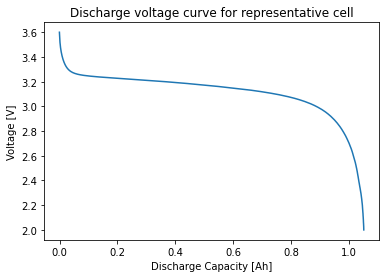

In [8]:
Qd = data_train[21,:,98]
Voltage = np.linspace(3.6, 2, 1000) # Batteries cycled from 3.6 V to 2 V

plt.plot(Qd, Voltage)
plt.xlabel("Discharge Capacity [Ah]")
plt.ylabel("Voltage [V]")
plt.title("Discharge voltage curve for representative cell")
plt.show()

### Generate features

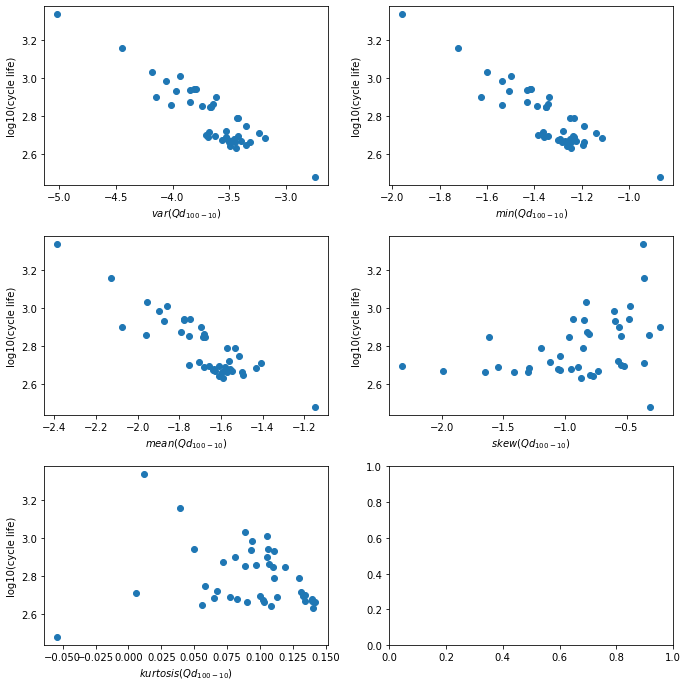

(41,)
(41,)
(41, 1000)
(41,)


In [16]:
# Define Qd100_10 which all features are based on
Qd100_10 = data_train[:, :, 98] - data_train[:, :, 8]

var_Qd = np.zeros(data_train.shape[0])
min_Qd = np.zeros(data_train.shape[0])
mean_Qd = np.zeros(data_train.shape[0])
skew_Qd = np.zeros(data_train.shape[0])
kurtosis_Qd = np.zeros(data_train.shape[0])

for i in range(data_train.shape[0]):
    var_Qd[i] = np.log10(abs(np.var(Qd100_10[i,:]))) # Var(Qd100-Qd10)
    min_Qd[i] = np.log10(abs(np.min(Qd100_10[i,:])))
    mean_Qd[i] = np.log10(abs(np.mean(Qd100_10[i,:])))
    skew_Qd[i] = np.log10(abs(skew(Qd100_10[i,:])))
    kurtosis_Qd[i] = np.log10(abs(kurtosis(Qd100_10[i,:])))
    
    

fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(10,10))
fig.tight_layout(pad=3.0)

ax[0,0].scatter(var_Qd, y_train)
ax[0,0].set_xlabel('$var(Qd_{100-10})$')
ax[0,0].set_ylabel('log10(cycle life)')

ax[0,1].scatter(min_Qd, y_train)
ax[0,1].set_xlabel('$min(Qd_{100-10})$')
ax[0,1].set_ylabel('log10(cycle life)')

ax[1,0].scatter(mean_Qd, y_train)
ax[1,0].set_xlabel('$mean(Qd_{100-10})$')
ax[1,0].set_ylabel('log10(cycle life)')

ax[1,1].scatter(skew_Qd, y_train)
ax[1,1].set_xlabel('$skew(Qd_{100-10})$')
ax[1,1].set_ylabel('log10(cycle life)')

ax[2,0].scatter(kurtosis_Qd, y_train)
ax[2,0].set_xlabel('$kurtosis(Qd_{100-10})$')
ax[2,0].set_ylabel('log10(cycle life)')

plt.show()

print(var_Qd.shape)
print(y_train.shape)
print(Qd100_10.shape)
print(skew_Qd.shape)

### Variance model <a class="anchor" id="variance"></a>

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


OLS regression errors
(103.57307084582933, 138.3328805365066, 195.8670275153622)
Elastic net errors
(103.64412937875144, 138.4610915461024, 196.05515947517466)


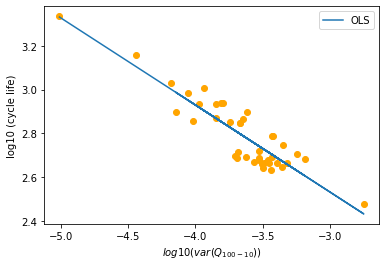

In [57]:
x_train = var_Qd.reshape(-1,1)
x_test1 = np.log10(np.var((data_test1[:,:,98] - data_test1[:,:,8]), axis=1)).reshape(-1,1)
x_test2 = np.log10(np.var((data_test2[:,:,98] - data_test2[:,:,8]), axis=1)).reshape(-1,1)

linreg = LinearRegression()
eNet = ElasticNetCV()

linreg.fit(x_train, y_train.reshape(-1,1))
eNet.fit(x_train, y_train.reshape(-1,1))

ypred_train = linreg.predict(x_train)
ypred_test1 = linreg.predict(x_test1)
ypred_test2 = linreg.predict(x_test2)

print("OLS regression errors")
print(RMSE_All_Datasets(ypred_train, ypred_test1, ypred_test2))

ypred_train = eNet.predict(x_train)
ypred_test1 = eNet.predict(x_test1)
ypred_test2 = eNet.predict(x_test2)

print("Elastic net errors")
print(RMSE_All_Datasets(ypred_train, ypred_test1, ypred_test2))


plt.scatter(x_train, y_train, color="orange")
plt.plot(x_train, ypred_ols, label="OLS")
plt.xlabel("$log10(var(Q_{100-10}))$")
plt.ylabel("log10 (cycle life)")
plt.legend()
plt.show()

In [61]:
functions = {
             'training set mean':          lambda x: np.mean(y_train) * np.ones((len(x),)),   
             'min($\Delta Q_{100-10}$)':   lambda x: np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)':   lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 90, axis=1),
             'IQR($\Delta Q_{100-10}$)':   lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1)
            }



transforms = {
              'Original':     lambda x: x,
              '$log_{10}$':   lambda x: np.log10(x)
             }

In [62]:
for i, func in enumerate(functions):
    print(func)
    for j, trans in enumerate(transforms):
        print(trans)


training set mean
Original
$log_{10}$
min($\Delta Q_{100-10}$)
Original
$log_{10}$
IDR($\Delta Q_{100-10}$)
Original
$log_{10}$
IQR($\Delta Q_{100-10}$)
Original
$log_{10}$
